In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Sat Jan 20 04:50:12 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   27C    P0    41W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -8
hp.const_sigma = True
hp.quantize = True

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 2195, model_list, optimizer_list)

total 892224
-rw-rw-r-- 1 scpark scpark    689133  1월 20 04:50 events.out.tfevents.1705693523.GPUSVR11
-rw-rw-r-- 1 scpark scpark 455049855  1월 20 04:45 save_0
-rw-rw-r-- 1 scpark scpark    109045  1월 20 04:45 events.out.tfevents.1705693455.GPUSVR11
-rw-rw-r-- 1 scpark scpark   2057447  1월 20 04:44 events.out.tfevents.1705692613.GPUSVR11
-rw-rw-r-- 1 scpark scpark 455057031  1월 20 04:40 save_10000
-rw-rw-r-- 1 scpark scpark    657013  1월 20 04:30 events.out.tfevents.1705692332.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 20 04:25 events.out.tfevents.1705692266.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

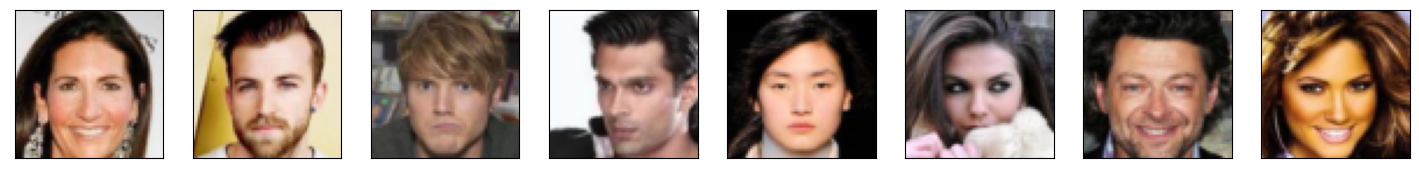

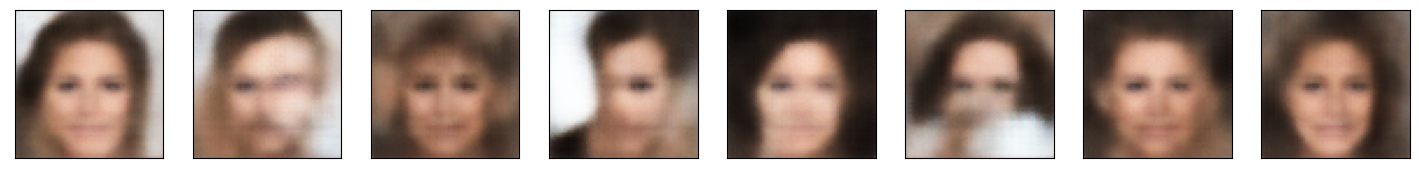

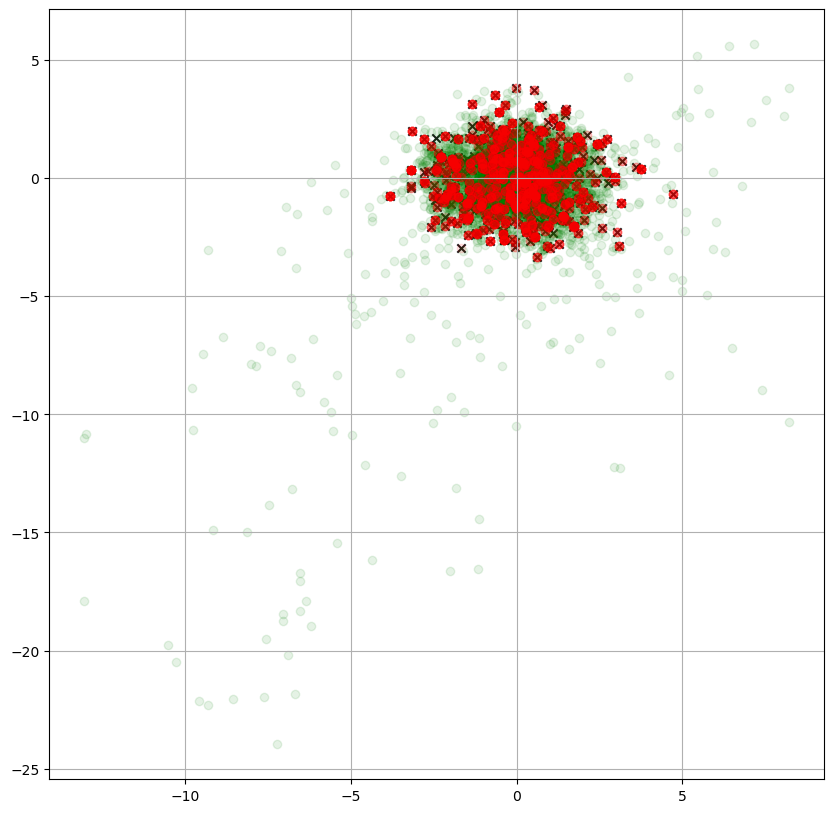

6001
lse_loss 38173456.0
commit_loss 1.6423816680908203
recon_loss 0.016958918422460556
6002
lse_loss 37208464.0
commit_loss 1.5753509998321533
recon_loss 0.02026592381298542
6003
lse_loss 34219440.0
commit_loss 1.6031193733215332
recon_loss 0.015690093860030174
6004
lse_loss 41756848.0
commit_loss 1.5962624549865723
recon_loss 0.014620731584727764
6005
lse_loss 39127256.0
commit_loss 1.6423468589782715
recon_loss 0.01696651615202427
6006
lse_loss 41850792.0
commit_loss 1.6149108409881592
recon_loss 0.017222300171852112
6007
lse_loss 41209664.0
commit_loss 1.5972652435302734
recon_loss 0.01713426224887371
6008
lse_loss 40213480.0
commit_loss 1.6445732116699219
recon_loss 0.017729399725794792
6009
lse_loss 35891936.0
commit_loss 1.5851194858551025
recon_loss 0.01598556712269783
6010
lse_loss 45283824.0
commit_loss 1.6026560068130493
recon_loss 0.018247876316308975
6011
lse_loss 40642584.0
commit_loss 1.6455881595611572
recon_loss 0.01497825887054205
6012
lse_loss 36388856.0
commit_loss 

6097
lse_loss 35566760.0
commit_loss 1.5802698135375977
recon_loss 0.01910504885017872
6098
lse_loss 40159176.0
commit_loss 1.6243600845336914
recon_loss 0.017507020384073257
6099
lse_loss 38006320.0
commit_loss 1.637870192527771
recon_loss 0.016437863931059837
6100
lse_loss 42216248.0
commit_loss 1.5631532669067383
recon_loss 0.02062254771590233
6101
lse_loss 37852656.0
commit_loss 1.593985915184021
recon_loss 0.015448128804564476
6102
lse_loss 64210316.0
commit_loss 1.5961588621139526
recon_loss 0.025864481925964355
6103
lse_loss 38125060.0
commit_loss 1.5798044204711914
recon_loss 0.01683955453336239
6104
lse_loss 41362284.0
commit_loss 1.6475967168807983
recon_loss 0.01900743506848812
6105
lse_loss 40649064.0
commit_loss 1.5734996795654297
recon_loss 0.020336806774139404
6106
lse_loss 38792368.0
commit_loss 1.6475207805633545
recon_loss 0.018285300582647324
6107
lse_loss 40271752.0
commit_loss 1.6411786079406738
recon_loss 0.016993071883916855
6108
lse_loss 39901244.0
commit_loss 1

6192
lse_loss 35961304.0
commit_loss 1.5736819505691528
recon_loss 0.020003844052553177
6193
lse_loss 37423432.0
commit_loss 1.6192024946212769
recon_loss 0.017786089330911636
6194
lse_loss 35619172.0
commit_loss 1.604286789894104
recon_loss 0.016500744968652725
6195
lse_loss 35959360.0
commit_loss 1.6198101043701172
recon_loss 0.017805181443691254
6196
lse_loss 37665536.0
commit_loss 1.6599476337432861
recon_loss 0.015895754098892212
6197
lse_loss 37922192.0
commit_loss 1.6371114253997803
recon_loss 0.020789166912436485
6198
lse_loss 38431408.0
commit_loss 1.5826406478881836
recon_loss 0.01582377403974533
6199
lse_loss 43725728.0
commit_loss 1.5976828336715698
recon_loss 0.017727000638842583
6200
lse_loss 36205544.0
commit_loss 1.5642555952072144
recon_loss 0.018049413338303566
6201
lse_loss 39748060.0
commit_loss 1.5748322010040283
recon_loss 0.018295615911483765
6202
lse_loss 40836356.0
commit_loss 1.5891871452331543
recon_loss 0.022054161876440048
6203
lse_loss 35150680.0
commit_lo

In [ ]:
from IPython import display

min_indices = set()
while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 5*1000)
            data = model(data, quant_temp=quant_temp, latent_temp=1)
            min_indices.update(list(data['min_indices'].data.cpu().numpy()))

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] #* linear(1, 0, step, 0, 5*1000)
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * linear(0, 1, step, 0, 5*1000)
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
            #alpha = 1e-3
            #model.prior.prior.data = (1-alpha)*model.prior.prior.data + alpha*data['e_new'].data
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            ze_pca = pca.transform(data['ze'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            zq_pca = pca.transform(data['zq'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.9, color='black')
            plt.scatter(ze_pca[:, 0], ze_pca[:, 1], marker='o', alpha=0.1, color='green')
            plt.scatter(zq_pca[:, 0], zq_pca[:, 1], marker='o', alpha=0.1, color='red')
            plt.grid()
            plt.show() 
            
            usage = len(min_indices) / hp.n_prior_embeddings
            writer.add_scalar('usage', usage, step)
            min_indices = set()
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [12]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


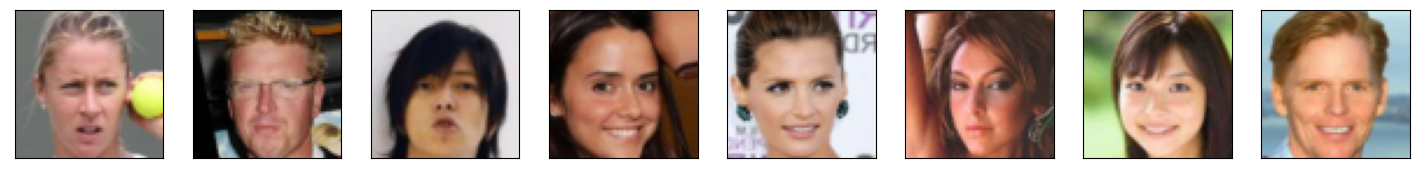

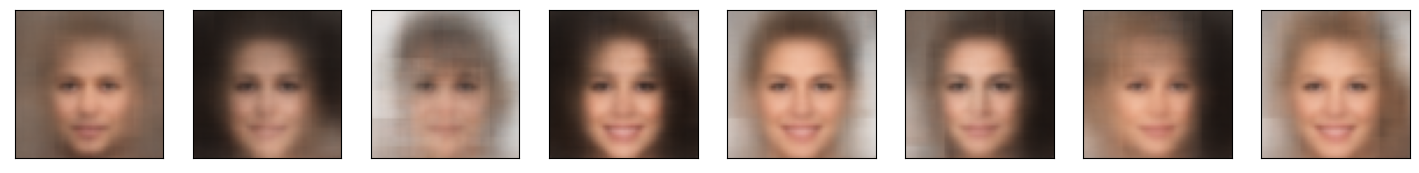

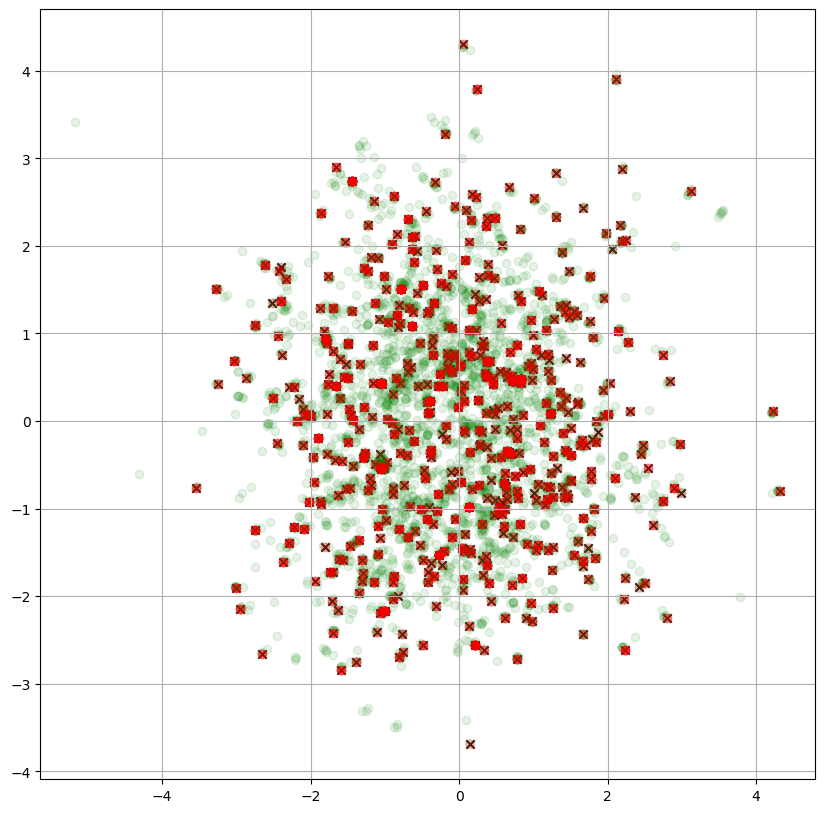

In [15]:
import matplotlib.pyplot as plt
display.clear_output()

data = preprocess(batch)

# Forward
model.train()
model.zero_grad()
quant_temp = linear(1, 0, step, 0, 5*1000)
data = model(data, quant_temp=quant_temp, latent_temp=1)

x = data['x']
y = data['y']

plot(x)
plot(y)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
ze_pca = pca.transform(data['ze'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
zq_pca = pca.transform(data['zq'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.9, color='black')
plt.scatter(ze_pca[:, 0], ze_pca[:, 1], marker='o', alpha=0.1, color='green')
plt.scatter(zq_pca[:, 0], zq_pca[:, 1], marker='o', alpha=0.1, color='red')
plt.grid()
plt.show() 

usage = len(min_indices) / hp.n_prior_embeddings
writer.add_scalar('usage', usage, step)
min_indices = set()